In [ ]:
!pip install gymnasium
!pip install pyvirtualdisplay
!pip install imageio
!pip install imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.5 MB/s eta 0:00:00


Эпизод: 0, Награда: -1021.4591297807822, Время: 0.14 сек
Эпизод: 1, Награда: -1439.260633633494, Время: 0.15 сек
Эпизод: 2, Награда: -1355.3026159058659, Время: 0.15 сек
Эпизод: 3, Награда: -1482.446509939193, Время: 0.15 сек
Эпизод: 4, Награда: -1868.6011410415267, Время: 0.14 сек
Эпизод: 5, Награда: -1303.2577109817885, Время: 0.15 сек
Эпизод: 6, Награда: -1433.3879828264353, Время: 0.14 сек
Эпизод: 7, Награда: -1489.2679905154146, Время: 0.14 сек
Эпизод: 8, Награда: -1893.854998719134, Время: 0.15 сек
Эпизод: 9, Награда: -1825.6390636117878, Время: 0.14 сек
Эпизод: 10, Награда: -1641.4484217965041, Время: 0.16 сек
Эпизод: 11, Награда: -1628.0493639732194, Время: 0.14 сек
Эпизод: 12, Награда: -1848.2683243265892, Время: 0.15 сек
Эпизод: 13, Награда: -1098.4900253021221, Время: 0.14 сек
Эпизод: 14, Награда: -1128.2078359358345, Время: 0.14 сек
Эпизод: 15, Награда: -1857.0689968728936, Время: 0.15 сек
Эпизод: 16, Награда: -1627.4262153821471, Время: 0.16 сек
Эпизод: 17, Награда: -1552.

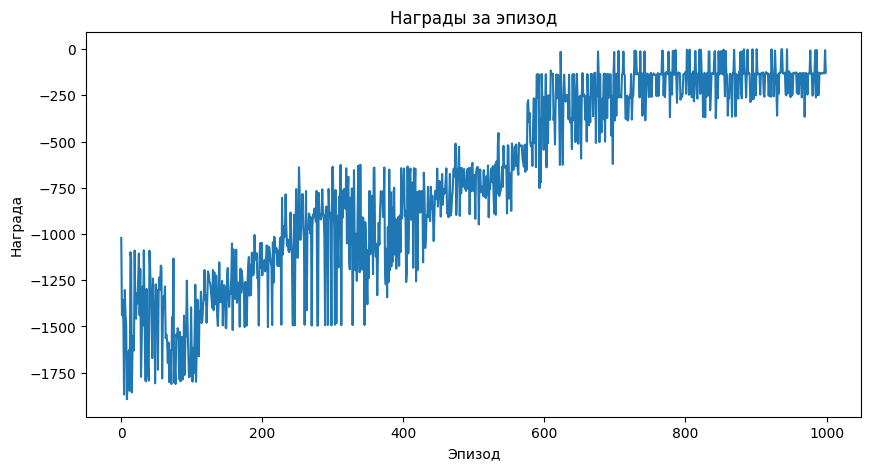

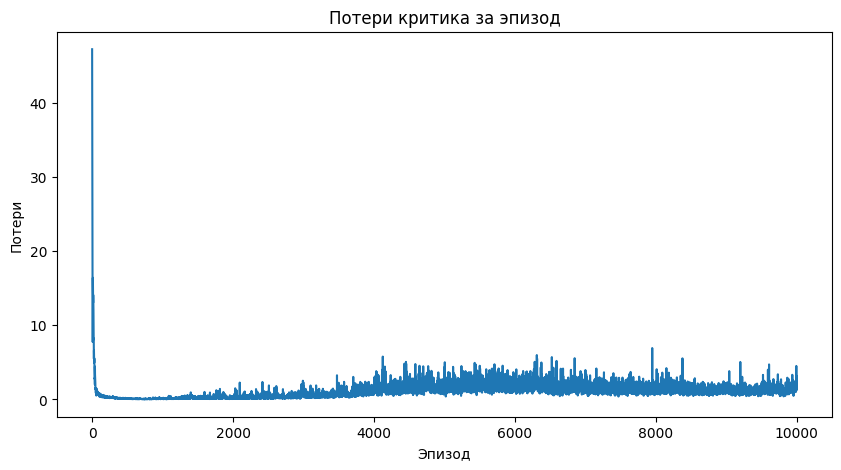

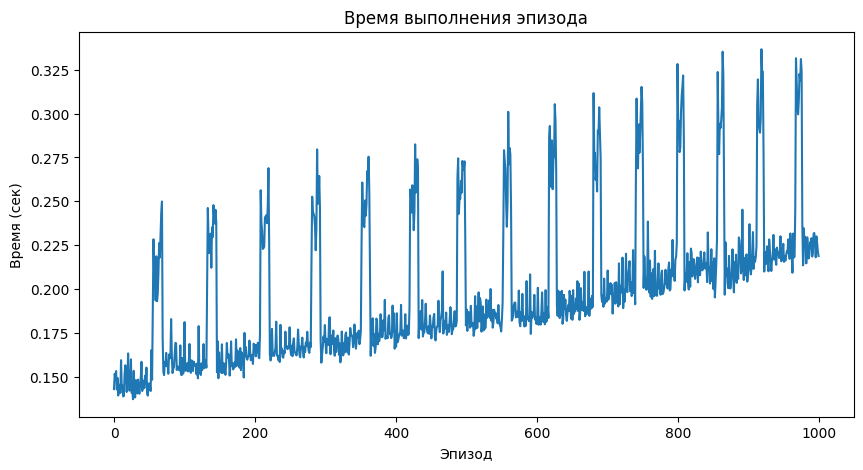

Время сходимости: 147.43 сек


ValueError: ('Render mode is None, which is incompatible with RecordVideo.', 'Initialize your environment with a render_mode that returns an image, such as rgb_array.')

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import time
from gymnasium.wrappers import RecordVideo
from pyvirtualdisplay import Display
import os

# Определение устройств для вычислений (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение класса Actor
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        x = self.max_action * torch.tanh(self.layer3(x))
        return x

# Определение класса Critic
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Определение класса DDPG
class DDPG:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = deque(maxlen=1000000)
        self.batch_size = 64

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, discount=0.99, tau=0.005):
        critic_losses = []
        for _ in range(iterations):
            # Выборка из реплей буфера
            experiences = replay_buffer.sample(self.batch_size)
            state, action, next_state, reward, not_done = zip(*experiences)

            state = torch.FloatTensor(np.array(state)).to(device)
            action = torch.FloatTensor(np.array(action)).to(device)
            next_state = torch.FloatTensor(np.array(next_state)).to(device)
            reward = torch.FloatTensor(np.array(reward)).to(device).unsqueeze(1)
            not_done = torch.FloatTensor(np.array(not_done)).to(device).unsqueeze(1)

            # Вычисление целевого Q-значения
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (not_done * discount * target_Q).detach()

            # Текущее Q-значение
            current_Q = self.critic(state, action)

            # Вычисление потерь критика
            critic_loss = nn.MSELoss()(current_Q, target_Q)
            critic_losses.append(critic_loss.item())

            # Оптимизация критика
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Вычисление потерь актера
            actor_loss = -self.critic(state, self.actor(state)).mean()

            # Оптимизация актера
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Обновление целевых моделей
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        return critic_losses

# Определение метода sample для deque
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]

# Определение функции обучения
def train_ddpg(env, agent, episodes=1000, max_timesteps=200, render=False):
    replay_buffer = ReplayBuffer()
    rewards = []
    losses = []
    episode_times = []
    convergence_time = None
    convergence_threshold = -200  # Порог для сходимости
    moving_average_window = 100  # Окно для скользящего среднего

    for episode in range(episodes):
        start_time = time.time()
        state, _ = env.reset()
        episode_reward = 0
        for t in range(max_timesteps):
            if render:
                env.render()

            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)

            replay_buffer.add((state, action, next_state, reward, float(not done)))

            state = next_state
            episode_reward += reward

            if done:
                break

        if len(replay_buffer.buffer) > agent.batch_size:
            critic_losses = agent.train(replay_buffer, iterations=10)
            losses.extend(critic_losses)

        rewards.append(episode_reward)
        episode_times.append(time.time() - start_time)
        print(f"Эпизод: {episode}, Награда: {episode_reward}, Время: {episode_times[-1]:.2f} сек")

        # Проверка на сходимость
        if len(rewards) >= moving_average_window:
            moving_average_reward = np.mean(rewards[-moving_average_window:])
            if moving_average_reward >= convergence_threshold and convergence_time is None:
                convergence_time = np.sum(episode_times)
                print(f"Модель сходится на эпизоде {episode} с временем {convergence_time:.2f} сек")

    return rewards, losses, episode_times, convergence_time

# Визуализация результатов
def plot_results(rewards, losses, episode_times, convergence_time):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title("Награды за эпизод")
    plt.xlabel("Эпизод")
    plt.ylabel("Награда")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Потери критика за эпизод")
    plt.xlabel("Эпизод")
    plt.ylabel("Потери")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(episode_times)
    plt.title("Время выполнения эпизода")
    plt.xlabel("Эпизод")
    plt.ylabel("Время (сек)")
    plt.show()

    if convergence_time is not None:
        print(f"Время сходимости: {convergence_time:.2f} сек")

# Функция тестирования
def test_agent_with_video(env, agent, episodes=10, max_timesteps=200, render=True, video_dir="videos"):
    env = RecordVideo(env, video_dir, episode_trigger=lambda x: True)
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        for t in range(max_timesteps):
            if render:
                env.render()

            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)

            state = next_state
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)
        print(f"Тестовый эпизод: {episode}, Награда: {episode_reward}")

    return rewards

# Основной код
if __name__ == "__main__":
    env = gym.make("Pendulum-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)
    rewards, losses, episode_times, convergence_time = train_ddpg(env, agent, episodes=1000)

    plot_results(rewards, losses, episode_times, convergence_time)

    # Тестирование обученного агента с записью видео
    test_rewards = test_agent_with_video(env, agent, episodes=10, video_dir="videos")


    # Отчет
    print("\nОтчет:")
    print("Описание реализованного алгоритма:")
    print("Реализовали алгоритм DDPG для задачи управления маятником. Алгоритм состоит из двух нейронных сетей: Actor и Critic.")
    print("Actor отвечает за выбор действий, а Critic оценивает Q-значение для пары состояние-действие.")
    print("Алгоритм обучается на основе опыта, который собирается в реплей буфере.")

    print("\nГрафики обучения:")
    print("Графики наград, потерь критика и времени выполнения эпизода построены.")

    print("\nВыводы о работе агента:")
    print(f"Средняя награда за обучение: {np.mean(rewards[-100:])}")
    print(f"Средняя награда за тестирование: {np.mean(test_rewards)}")
    print("Агент должен удерживать маятник в вертикальном положении, что должно привести к средней награде -200 или выше.")
    print("Стабильность обучения можно оценить по графику наград. Если график показывает плавное увеличение наград, то обучение стабильно.")
    print(f"Время сходимости: {convergence_time:.2f} сек")

    print("\nРекомендации по улучшению модели:")
    print("1. Использование более сложных архитектур нейронных сетей.")
    print("2. Изменение гиперпараметров.")
    print("3. Использование более сложных методов оптимизации.")
    print("4. Использование более сложных методов регуляризации.")
    print("5. Использование более сложных методов сбора опыта.")

In [ ]:
# Создание среды с режимом рендеринга "rgb_array"
env = gym.make("Pendulum-v1", render_mode="rgb_array")

# Тестирование обученного агента с записью видео
test_rewards = test_agent_with_video(env, agent, episodes=10, video_dir="videos")

# Отчет
print("\nОтчет:")
print(f"Средняя награда за тестирование: {np.mean(test_rewards)}")

Тестовый эпизод: 0, Награда: -254.5492815420941
Тестовый эпизод: 1, Награда: -123.46061360197199
Тестовый эпизод: 2, Награда: -240.40690333637647
Тестовый эпизод: 3, Награда: -243.33332899567597
Тестовый эпизод: 4, Награда: -127.41136486901844
Тестовый эпизод: 5, Награда: -125.78978132886682
Тестовый эпизод: 6, Награда: -130.72830151561067
Тестовый эпизод: 7, Награда: -0.40237609506019245
Тестовый эпизод: 8, Награда: -121.7941129702443
Тестовый эпизод: 9, Награда: -129.96022484309398

Отчет:
Средняя награда за тестирование: -149.78362890980128


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


In [ ]:
from IPython.display import HTML
import base64

def show_video(video_dir):
    video_list = os.listdir(video_dir)
    for video_name in video_list:
        if video_name.endswith(".mp4"):
            video_path = os.path.join(video_dir, video_name)
            video = open(video_path, 'rb').read()
            data_url = "data:video/mp4;base64," + base64.b64encode(video).decode()
            display(HTML("""
            <video width=400 controls>
                  <source src="%s" type="video/mp4">
            </video>
            """ % data_url))

show_video("videos")